In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


# Install required packages first
# !pip install kaggle kagglehub pandas pyunpack patool

import os
import shutil
import zipfile
import tempfile
from pathlib import Path
from google.colab import files as colab_files
import kagglehub

# ============================================
# SIMPLE KAGGLE TO DRIVE DOWNLOADER
# ============================================

def download_kaggle_to_drive(kaggle_path, drive_folder, unzip=True, cleanup=True):
    """
    Simple function to download Kaggle dataset to Google Drive

    Args:
        kaggle_path: Kaggle dataset path (e.g., "username/dataset-name" or full URL)
        drive_folder: Google Drive destination folder path
        unzip: Whether to unzip files automatically
        cleanup: Whether to delete temporary files

    Returns:
        Path to downloaded files in Google Drive
    """

    print(f"🚀 Starting download: {kaggle_path}")
    print(f"📁 Destination: {drive_folder}")

    # Step 1: Extract kaggle handle from input
    def get_kaggle_handle(input_path):
        """Extract kaggle handle from various input formats"""
        import re

        # Remove any query parameters
        input_path = input_path.split('?')[0]

        # Pattern to match kaggle dataset URLs
        patterns = [
            r'kaggle\.com/(?:datasets|competitions|codes)/([a-zA-Z0-9\-_]+/[a-zA-Z0-9\-_]+)',
            r'^([a-zA-Z0-9\-_]+/[a-zA-Z0-9\-_]+)$'
        ]

        for pattern in patterns:
            match = re.search(pattern, input_path)
            if match:
                return match.group(1)

        # If no pattern matches, return as-is
        return input_path

    # Get clean kaggle handle
    kaggle_handle = get_kaggle_handle(kaggle_path)
    print(f"🔍 Kaggle handle: {kaggle_handle}")

    # Step 2: Mount Google Drive (for Colab)
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        print("✅ Google Drive mounted")

        # Ensure drive folder is in the correct path
        if not drive_folder.startswith('/content/drive'):
            drive_folder = f"/content/drive/MyDrive/{drive_folder.lstrip('/')}"
    except ImportError:
        print("⚠️  Not in Google Colab - ensure drive_folder is correct path")

    # Create destination folder
    os.makedirs(drive_folder, exist_ok=True)
    print(f"📁 Created destination folder: {drive_folder}")

    # Step 3: Download from Kaggle
    try:
        print("⬇️  Downloading from Kaggle...")
        download_path = kagglehub.dataset_download(kaggle_handle)
        print(f"✅ Downloaded to: {download_path}")
    except Exception as e:
        print(f"❌ Kaggle download failed: {e}")

        # Try alternative method
        try:
            import subprocess
            import tempfile

            print("🔄 Trying alternative download method...")
            temp_dir = tempfile.mkdtemp()

            # Use kaggle CLI
            result = subprocess.run(
                ["kaggle", "datasets", "download", "-d", kaggle_handle, "-p", temp_dir],
                capture_output=True,
                text=True
            )

            if result.returncode == 0:
                # Find the downloaded file
                files = os.listdir(temp_dir)
                zip_files = [f for f in files if f.endswith('.zip')]

                if zip_files:
                    download_path = os.path.join(temp_dir, zip_files[0])
                    print(f"✅ Downloaded zip file: {download_path}")
                else:
                    download_path = temp_dir
                    print(f"✅ Downloaded to directory: {download_path}")
            else:
                print(f"❌ Alternative method failed: {result.stderr}")
                return None

        except Exception as e2:
            print(f"❌ All download methods failed: {e2}")
            return None

    # Step 4: Process and copy files
    print("\n📊 Processing files...")

    def copy_files(source, destination):
        """Copy files from source to destination"""
        if os.path.isfile(source):
            # Single file
            shutil.copy2(source, destination)
            return 1
        else:
            # Directory
            count = 0
            for item in os.listdir(source):
                source_path = os.path.join(source, item)
                dest_path = os.path.join(destination, item)

                if os.path.isdir(source_path):
                    shutil.copytree(source_path, dest_path, dirs_exist_ok=True)
                    # Count files in subdirectory
                    for root, dirs, files in os.walk(source_path):
                        count += len(files)
                else:
                    shutil.copy2(source_path, dest_path)
                    count += 1
            return count

    # Check if download is a zip file
    if os.path.isfile(download_path) and download_path.endswith('.zip') and unzip:
        print(f"📦 Extracting zip file: {os.path.basename(download_path)}")

        # Create extraction directory
        extract_dir = os.path.join(drive_folder, "extracted")
        os.makedirs(extract_dir, exist_ok=True)

        # Extract zip
        try:
            with zipfile.ZipFile(download_path, 'r') as zip_ref:
                zip_ref.extractall(extract_dir)

            # Count extracted files
            extracted_count = 0
            for root, dirs, files in os.walk(extract_dir):
                extracted_count += len(files)

            print(f"✅ Extracted {extracted_count} files to: {extract_dir}")

            # Move files from extracted folder to main folder
            for item in os.listdir(extract_dir):
                source = os.path.join(extract_dir, item)
                dest = os.path.join(drive_folder, item)

                if os.path.isdir(source):
                    shutil.move(source, dest)
                else:
                    shutil.move(source, dest)

            # Remove empty extract directory
            os.rmdir(extract_dir)

        except Exception as e:
            print(f"❌ Failed to extract zip: {e}")
            print("📄 Copying zip file as-is...")
            shutil.copy2(download_path, os.path.join(drive_folder, os.path.basename(download_path)))

    else:
        # Copy files directly
        if os.path.isfile(download_path):
            # Single file
            shutil.copy2(download_path, os.path.join(drive_folder, os.path.basename(download_path)))
            print(f"✅ Copied file: {os.path.basename(download_path)}")
        else:
            # Directory
            copied_count = copy_files(download_path, drive_folder)
            print(f"✅ Copied {copied_count} files")

    # Step 5: Cleanup
    if cleanup:
        try:
            if os.path.isfile(download_path):
                os.remove(download_path)
            else:
                shutil.rmtree(download_path)
            print("🧹 Cleaned up temporary files")
        except Exception as e:
            print(f"⚠️  Could not clean up temp files: {e}")

    # Step 6: Show summary
    print("\n" + "="*50)
    print("✅ DOWNLOAD COMPLETE!")
    print("="*50)

    # List files in destination
    print(f"\n📁 Files in {drive_folder}:")
    files_list = os.listdir(drive_folder)
    for i, file in enumerate(files_list[:20]):  # Show first 20 files
        file_path = os.path.join(drive_folder, file)
        if os.path.isfile(file_path):
            size = os.path.getsize(file_path)
            print(f"  {i+1:2d}. {file} ({size:,} bytes)")
        else:
            print(f"  {i+1:2d}. {file}/ (folder)")

    if len(files_list) > 20:
        print(f"  ... and {len(files_list) - 20} more items")

    print(f"\n📍 Total files/folders: {len(files_list)}")

    return drive_folder

# ============================================
# UPLOAD FROM COMPUTER FUNCTION
# ============================================

def upload_to_drive(local_folder=None, drive_folder=None):
    """
    Upload files from local computer to Google Drive

    Args:
        local_folder: If None, upload via Colab file dialog
        drive_folder: Google Drive destination folder
    """

    print("💻 UPLOAD FROM COMPUTER")
    print("="*50)

    # Mount Google Drive
    try:
        from google.colab import drive
        drive.mount('/content/drive')

        if drive_folder and not drive_folder.startswith('/content/drive'):
            drive_folder = f"/content/drive/MyDrive/{drive_folder.lstrip('/')}"
    except ImportError:
        print("⚠️  Not in Google Colab")
        if not drive_folder:
            drive_folder = input("Enter Google Drive folder path: ").strip()

    if not drive_folder:
        drive_folder = "/content/drive/MyDrive/Uploads"

    os.makedirs(drive_folder, exist_ok=True)
    print(f"📁 Destination: {drive_folder}")

    uploaded_files = []

    if local_folder:
        # Upload from specified local folder
        if os.path.exists(local_folder):
            print(f"📤 Uploading from local folder: {local_folder}")

            for item in os.listdir(local_folder):
                source = os.path.join(local_folder, item)
                dest = os.path.join(drive_folder, item)

                if os.path.isfile(source):
                    shutil.copy2(source, dest)
                    uploaded_files.append(item)
                    print(f"  ✅ {item}")
                else:
                    shutil.copytree(source, dest, dirs_exist_ok=True)
                    uploaded_files.append(f"{item}/")
                    print(f"  ✅ {item}/")
        else:
            print(f"❌ Local folder not found: {local_folder}")
            return None

    else:
        # Upload via Colab file dialog
        try:
            print("📤 Please select files to upload...")
            uploaded = colab_files.upload()

            if uploaded:
                for filename, content in uploaded.items():
                    dest_path = os.path.join(drive_folder, filename)

                    # Save file
                    with open(dest_path, 'wb') as f:
                        f.write(content)

                    uploaded_files.append(filename)
                    print(f"  ✅ {filename}")
            else:
                print("⚠️  No files selected")
                return None

        except Exception as e:
            print(f"❌ Upload failed: {e}")
            return None

    print(f"\n✅ Uploaded {len(uploaded_files)} files to: {drive_folder}")
    return drive_folder

# ============================================
# COMBINED FUNCTION WITH MENU
# ============================================

def data_transfer_tool():
    """
    Main function with menu to choose between Kaggle download or local upload
    """

    print("""
    ╔═══════════════════════════════════════╗
    ║       DATA TRANSFER TOOL              ║
    ║   Kaggle → Drive  or  Local → Drive   ║
    ╚═══════════════════════════════════════╝
    """)

    while True:
        print("\n" + "="*50)
        print("MAIN MENU")
        print("="*50)
        print("1. 📥 Download from Kaggle to Google Drive")
        print("2. 💻 Upload from computer to Google Drive")
        print("3. 🚪 Exit")

        choice = input("\nSelect option (1-3): ").strip()

        if choice == "1":
            print("\n📥 KAGGLE TO GOOGLE DRIVE")
            print("-"*30)

            # Get kaggle path
            print("\nEnter Kaggle dataset (any format):")
            print("Examples:")
            print("  - https://www.kaggle.com/datasets/jekiwantaufik/west-java-2014-2024")
            print("  - jekiwantaufik/west-java-2014-2024")

            kaggle_path = input("\nKaggle dataset: ").strip()

            if not kaggle_path:
                print("❌ No input provided")
                continue

            # Get drive folder
            default_drive = "/content/drive/MyDrive/Kaggle_Datasets"
            drive_folder = input(f"\nGoogle Drive folder [{default_drive}]: ").strip()
            if not drive_folder:
                drive_folder = default_drive

            # Options
            unzip_choice = input("\nUnzip files? (yes/no) [yes]: ").strip().lower()
            unzip = not unzip_choice or unzip_choice in ['yes', 'y', '1']

            cleanup_choice = input("Cleanup temporary files? (yes/no) [yes]: ").strip().lower()
            cleanup = not cleanup_choice or cleanup_choice in ['yes', 'y', '1']

            # Download
            download_kaggle_to_drive(kaggle_path, drive_folder, unzip, cleanup)

        elif choice == "2":
            print("\n💻 UPLOAD FROM COMPUTER")
            print("-"*30)

            # Get source
            print("\nChoose source:")
            print("1. Upload via file dialog (Colab)")
            print("2. Specify local folder path")

            source_choice = input("\nSelect (1 or 2): ").strip()

            if source_choice == "1":
                local_folder = None
            elif source_choice == "2":
                local_folder = input("\nEnter local folder path: ").strip()
                if not os.path.exists(local_folder):
                    print(f"❌ Folder not found: {local_folder}")
                    continue
            else:
                print("❌ Invalid choice")
                continue

            # Get drive folder
            default_drive = "/content/drive/MyDrive/Uploads"
            drive_folder = input(f"\nGoogle Drive folder [{default_drive}]: ").strip()
            if not drive_folder:
                drive_folder = default_drive

            # Upload
            upload_to_drive(local_folder, drive_folder)

        elif choice == "3":
            print("👋 Goodbye!")
            break

        else:
            print("❌ Invalid choice")

        input("\nPress Enter to continue...")

# ============================================
# QUICK USAGE EXAMPLES
# ============================================

# Example 1: Direct Kaggle download
def example_kaggle():
    """Example: Download a Kaggle dataset"""
    download_kaggle_to_drive(
        kaggle_path="https://www.kaggle.com/datasets/jekiwantaufik/west-java-2014-2024",
        drive_folder="/content/drive/MyDrive/Datasets/WestJava",
        unzip=True,
        cleanup=True
    )

# Example 2: Direct upload
def example_upload():
    """Example: Upload from computer"""
    upload_to_drive(
        local_folder=None,  # Will use Colab file dialog
        drive_folder="/content/drive/MyDrive/Uploads"
    )

# Example 3: Upload specific folder
def example_upload_folder():
    """Example: Upload specific folder"""
    upload_to_drive(
        local_folder="/path/to/your/local/folder",
        drive_folder="/content/drive/MyDrive/MyProject/Data"
    )

# ============================================
# RUN THE TOOL
# ============================================

if __name__ == "__main__":
    # Run the interactive tool
    data_transfer_tool()

    # Or use directly:
    # download_kaggle_to_drive("username/dataset", "/content/drive/MyDrive/MyFolder")


In [3]:
# Import necessary libraries

from transformers import CLIPTokenizer # Tokenizer for the CLIP model, converts text into tokens
from transformers import CLIPProcessor # Preprocessor for CLIP model, handles image/text preprocessing
from transformers import CLIPModel     # CLIP model for image-text embedding and similarity tasks

import torch                           # PyTorch library, used for tensor operations and GPU computations
import torch.nn.functional as F        # Contains functional API for neural network operations (e.g., activations, loss functions)
import numpy as np                     # Numerical library for array manipulation and computations

import matplotlib.pyplot as plt        # Library for plotting images and visualizations
import seaborn as sns                  # Library for creating statistical visualizations

from PIL import Image                  # Used for loading and processing images
import requests                        # Used to fetch images from URLs
from io import BytesIO                 # Enables reading binary data as file-like objects in memory

In [4]:
##definen the model name for the clip varient (Vision Transformer -base,32X32 patches)
model_name='openai/clip-vit-base-patch32'
##Load the model
model=CLIPModel.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [6]:
##Tokenize Txt String
'''
We first convert the text string into tokens.Roughly speaking  a token is a numerical represtation
of a word.When a string is tokenzed it is a Padded with start and end token
'''
##Load the tokenizer associated with the specified CLIP model
tokenizer = CLIPTokenizer.from_pretrained(model_name)
##Define a list of text descriptions to embed
text = ['a donut', 'a cookie', 'an airplane', 'a cat']
##Tokenize and Preprocess the text inputs with padding to ensure equal sequence lengths
inputs = tokenizer(text, padding=True, return_tensors="pt")
##Unpack the inputs
input_ids = inputs.input_ids  ##Tokenized and encoded text input IDs
##Print information about the unpacked inputs
print(f"Input IDs (shape): {input_ids.shape}")
print(input_ids)

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Input IDs (shape): torch.Size([4, 4])
tensor([[49406,   320, 18471, 49407],
        [49406,   320,  9367, 49407],
        [49406,   550, 16451, 49407],
        [49406,   320,  2368, 49407]])


In [8]:
##Find Text Embedding
##Compute text embedding without tracking gradients (inference mode)
with torch.no_grad():
    ##Obtain text embedding (feature vectors) from the CLIP model
    text_embeddings = model.get_text_features(**inputs)
##Print the shape of the resulting text embedding tensor
##The Shape is (number of Texts, embedding_dimension)
print(text_embeddings.shape)

torch.Size([4, 512])


<Axes: >

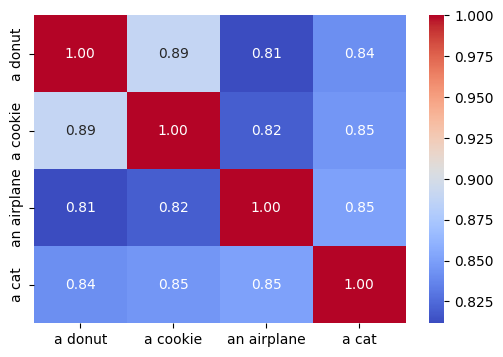

In [9]:
##Calculate the Cosine Similarity
cosine_similarity=F.cosine_similarity(
    text_embeddings[:,None,:],
    text_embeddings[None,:,:],
    dim=2
).cpu().numpy()
##Instialize a matplotlib figure with specified size (width=6,height=4)
plt.figure(figsize=(6,4))
#Create a heatmap visialization using seaborn to display the cosine similarity matrix
sns.heatmap(
    cosine_similarity,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    xticklabels=text,
    yticklabels=text
)

In [11]:
##Utility function for displaying images with labels
def plot_images(images,labels):
  n=len(images)
  fig,axes=plt.subplot(1,n)
  ##Loope throught each subplot axis,image and label to display them
  for ax,img,lbl in zip(axes,images,labels):
    ax.imshow(img)
    ax.set_title(lbl)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

Text embeddings shape: torch.Size([4, 512])


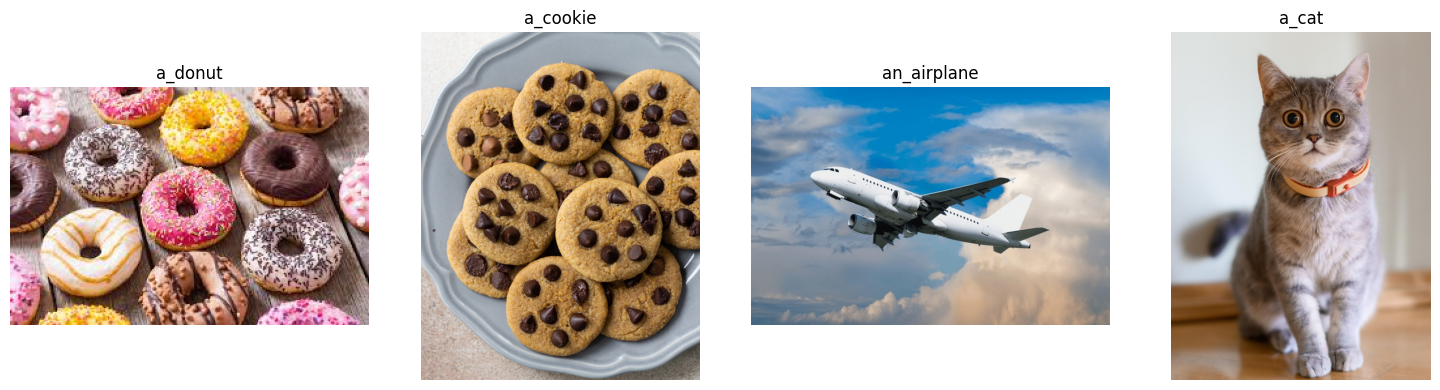

Image embeddings shape: torch.Size([4, 512])

Similarity scores:
a donut vs a_donut: 0.2719
a donut vs a_cookie: 0.1876
a donut vs an_airplane: 0.1494
a donut vs a_cat: 0.2278
a cookie vs a_donut: 0.2073
a cookie vs a_cookie: 0.2648
a cookie vs an_airplane: 0.1480
a cookie vs a_cat: 0.2378
an airplane vs a_donut: 0.1671
an airplane vs a_cookie: 0.1673
an airplane vs an_airplane: 0.2618
an airplane vs a_cat: 0.1974
a cat vs a_donut: 0.1673
a cat vs a_cookie: 0.1525
a cat vs an_airplane: 0.1598
a cat vs a_cat: 0.2755

Text to Image probabilities (softmax over images for each text):
P(a_donut|a donut): 0.2659
P(a_cookie|a donut): 0.2444
P(an_airplane|a donut): 0.2353
P(a_cat|a donut): 0.2544
P(a_donut|a cookie): 0.2480
P(a_cookie|a cookie): 0.2627
P(an_airplane|a cookie): 0.2337
P(a_cat|a cookie): 0.2557
P(a_donut|an airplane): 0.2421
P(a_cookie|an airplane): 0.2422
P(an_airplane|an airplane): 0.2662
P(a_cat|an airplane): 0.2496
P(a_donut|a cat): 0.2444
P(a_cookie|a cat): 0.2408
P(an_airp

In [20]:
import torch
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPTokenizer, CLIPModel
import numpy as np

# Load the model
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
tokenizer = CLIPTokenizer.from_pretrained(model_name)

# Define a list of text descriptions to embed
text = ['a donut', 'a cookie', 'an airplane', 'a cat']

# Tokenize and Preprocess the text inputs with padding
inputs = tokenizer(text, padding=True, return_tensors="pt")

# Find Text Embedding
with torch.no_grad():
    text_embeddings = model.get_text_features(**inputs)

print(f"Text embeddings shape: {text_embeddings.shape}")

# Load and display images
processor = CLIPProcessor.from_pretrained(model_name)

# Dictionary containing labels and their corresponding image URLs
image_url = {
    'a_donut': 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRgDeEGyhjkjqtUoGf-vsPsTV9rIIqhnbBYDg&s',
    'a_cookie': 'https://bakewithshivesh.com/wp-content/uploads/2020/09/IMG-8129-1-scaled.jpg',
    'an_airplane': 'https://www.shutterstock.com/image-photo/airplane-flying-sky-travel-background-600nw-2478264897.jpg',
    'a_cat': 'https://img.freepik.com/free-photo/portrait-beautiful-purebred-pussycat-with-shorthair-orange-collar-neck-sitting-floor-reacting-camera-flash-scared-looking-light-indoor_8353-12551.jpg?semt=ais_hybrid'
}

# Extract the list of labels from the dictionary keys
labels = list(image_url.keys())

# Define a robust function to load images from URLs
def load_image(url):
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    return Image.open(BytesIO(response.content)).convert("RGB")

# Initialize empty list for successfully loaded images
images = []

# Loop through each label to load the associated image
for label in labels:
    try:
        img = load_image(image_url[label])
        images.append(img)
    except requests.exceptions.RequestException as e:
        print(f"Failed to load {label}: {e}")

# Display images function
def plot_images(images, labels):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 4))

    # If there's only 1 image, axes is not an array
    if num_images == 1:
        axes = [axes]

    for i, (img, label) in enumerate(zip(images, labels)):
        # Convert PIL Image to numpy array for matplotlib
        axes[i].imshow(np.array(img))
        axes[i].set_title(label)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Display the loaded images
plot_images(images, labels)

# Process images for CLIP
image_inputs = processor(images=images, return_tensors="pt")

# Get image embeddings
with torch.no_grad():
    image_embeddings = model.get_image_features(**image_inputs)

print(f"Image embeddings shape: {image_embeddings.shape}")

# Compute similarity between text and image embeddings
# Reshape tensors to compute pairwise similarity
similarity_scores = torch.zeros(len(text), len(labels))

for i in range(len(text)):
    for j in range(len(labels)):
        # Compute cosine similarity between text i and image j
        sim = torch.nn.functional.cosine_similarity(
            text_embeddings[i:i+1],
            image_embeddings[j:j+1],
            dim=-1
        )
        similarity_scores[i, j] = sim

print("\nSimilarity scores:")
for i, txt in enumerate(text):
    for j, label in enumerate(labels):
        print(f"{txt} vs {label}: {similarity_scores[i, j].item():.4f}")

# Find best matches - Convert to numpy to avoid tensor indexing issues
similarity_np = similarity_scores.detach().numpy()

print("\nText to Image probabilities (softmax over images for each text):")
for i, txt in enumerate(text):
    # Apply softmax to the i-th row
    row = similarity_np[i]
    exp_row = np.exp(row - np.max(row))  # Numerical stability
    probs = exp_row / exp_row.sum()

    for j, label in enumerate(labels):
        print(f"P({label}|{txt}): {probs[j]:.4f}")

print("\nImage to Text probabilities (softmax over texts for each image):")
for j, label in enumerate(labels):
    # Apply softmax to the j-th column
    col = similarity_np[:, j]
    exp_col = np.exp(col - np.max(col))  # Numerical stability
    probs = exp_col / exp_col.sum()

    for i, txt in enumerate(text):
        print(f"P({txt}|{label}): {probs[i]:.4f}")

# Find best matches for each text
print("\nBest matches for each text:")
for i, txt in enumerate(text):
    row = similarity_np[i]
    best_idx = np.argmax(row)
    best_prob = np.exp(row[best_idx] - np.max(row)) / np.sum(np.exp(row - np.max(row)))
    print(f"{txt} best matches: {labels[best_idx]} (prob: {best_prob:.4f})")

# Find best matches for each image
print("\nBest matches for each image:")
for j, label in enumerate(labels):
    col = similarity_np[:, j]
    best_idx = np.argmax(col)
    best_prob = np.exp(col[best_idx] - np.max(col)) / np.sum(np.exp(col - np.max(col)))
    print(f"{label} best matches: '{text[best_idx]}' (prob: {best_prob:.4f})")

torch.Size([4, 512])


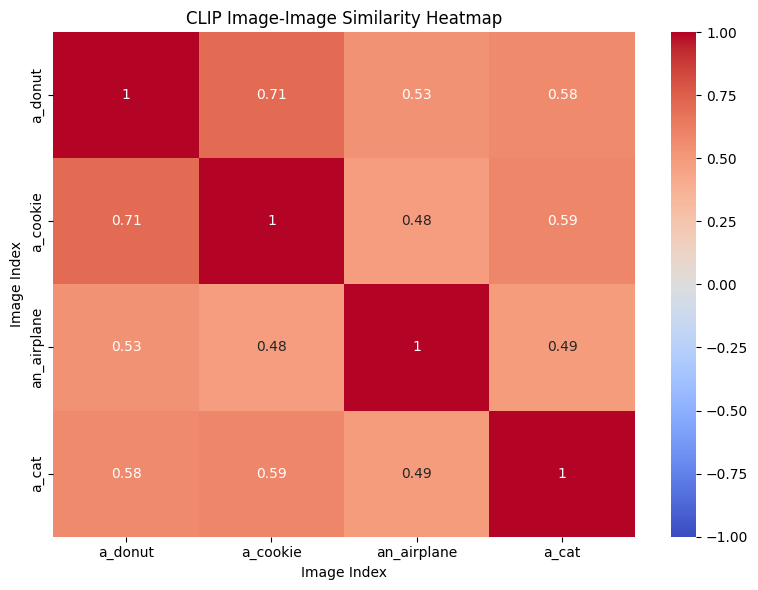

In [25]:
import seaborn as sns
import torch.nn.functional as F

##Calculate Image Embedding and Display Similarity
##Preprocess images using CLIP processor to prepare for embedding generation
image_inputs = processor(images=images, return_tensors='pt')
with torch.no_grad():
    ##Generate image embedding using the CLIP model
    image_embeddings = model.get_image_features(**image_inputs)
##Print the shape of the resulting image embedding tensor
##The Shape is [number of images, embedding_dimension]
print(image_embeddings.shape)

##Compute similarity matrix
image_similarity = F.cosine_similarity(
    image_embeddings[:, None, :],
    image_embeddings[None, :, :],
    dim=-1  # Changed from dim=2 to dim=-1
).cpu().numpy()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    image_similarity,
    annot=True,
    xticklabels=labels,
    yticklabels=labels,
    cmap='coolwarm',  # Fixed typo: camp -> cmap
    vmin=-1,  # Added for better visualization
    vmax=1    # Added for better visualization
)
plt.xlabel("Image Index")
plt.ylabel("Image Index")
plt.title("CLIP Image-Image Similarity Heatmap")  # Fixed typo: CLP -> CLIP
plt.tight_layout()
plt.show()

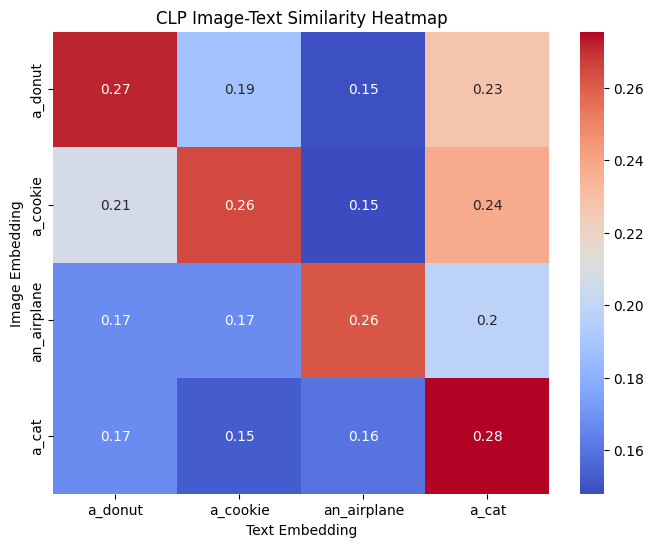

In [27]:
##Calculate Image -Text similarity
##Computer similarity matrix
txt_image_similarity=F.cosine_similarity(
    text_embeddings[:,None,:],
    image_embeddings[None,:,:],
    dim=2
).cpu().numpy()
##Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(txt_image_similarity,
            annot=True,
            xticklabels=labels,
            yticklabels=labels,
            cmap='coolwarm'
            )
plt.xlabel("Text Embedding")
plt.ylabel("Image Embedding")
plt.title("CLP Image-Text Similarity Heatmap")
plt.show()